In [1]:
import pandas as pd
import numpy as np
import glob, os
from tqdm import tqdm
import _thread
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

TRAIN_DATA_FOLDER = './data/EURUSD'
TEST_DATA_FOLDER = './data/EURUSD/test'
PAIR = 'EURUSD'
MINUTES_TO_LOOK_FORWARD = 240
DELTA = 0

# Prepare Data

In [2]:
def aggregate_data_into_one_frame(data_path):
    all_files = glob.glob(data_path + '*.csv')
    csv_all_content = []

    for filename in all_files:
        temp_df = pd.read_csv(filename, index_col=None, header=None)
        csv_all_content.append(temp_df)

    return pd.concat(csv_all_content, axis=0, ignore_index=True)

def arrange_data(df):
    df.columns = ['Date', 'Time', 'Open', 'Highest', 'Close', 'Lowest', 'NaN']
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    df = df[['Datetime','Open','Highest','Close', 'Lowest']]
    df['goLong'] = 0
    return df

def set_long_or_short(df, minutes_to_look_forward):
    for i in tqdm(range(len(df) - minutes_to_look_forward)):
        current_close = df.iloc[i]['Close']
        next_sample = df.iloc[i:minutes_to_look_forward + i]
        max_close = next_sample.iloc[next_sample['Close'].idxmax() - i]['Close']
        min_close = next_sample.iloc[next_sample['Close'].idxmin() - i]['Close']
        if max_close - current_close > current_close - min_close:
            df.at[i, 'goLong'] = 1
    return df

def load_or_process_data(data_folder, currency, minutes, delta):
    if os.path.isfile(f'{data_folder}/preprocessed/{currency}_{minutes}min_{delta}delta.csv'):
        df = pd.read_csv(f'{data_folder}/preprocessed/{currency}_{minutes}min_{delta}delta.csv', header=0)
        df['Datetime'] = pd.to_datetime(df['Datetime'])
    else:
        df = aggregate_data_into_one_frame(f'{data_folder}/')
        df = arrange_data(df)
        df = set_long_or_short(df, minutes)
        df.to_csv(f'{data_folder}/preprocessed/{currency}_{minutes}min_{delta}delta.csv', index=False)
    return df

In [3]:
df_train = load_or_process_data(TRAIN_DATA_FOLDER, PAIR, MINUTES_TO_LOOK_FORWARD, DELTA)
df_test = load_or_process_data(TEST_DATA_FOLDER, PAIR, MINUTES_TO_LOOK_FORWARD, DELTA)

In [4]:
df_train.head()

,Datetime,Open,Highest,Close,Lowest,goLong
0,2000-05-30 17:27:00,0.9302,0.9302,0.9302,0.9302,1
1,2000-05-30 17:35:00,0.9304,0.9305,0.9304,0.9305,0
2,2000-05-30 17:38:00,0.9304,0.9304,0.9303,0.9303,0
3,2000-05-30 17:43:00,0.9301,0.9301,0.9300,0.9300,1
4,2000-05-30 17:44:00,0.9298,0.9298,0.9297,0.9297,1


In [5]:
df_test.head()

,Datetime,Open,Highest,Close,Lowest,goLong
0,2019-01-01 17:02:00,1.14598,1.14599,1.14598,1.14598,0
1,2019-01-01 17:03:00,1.14598,1.14607,1.14598,1.14607,0
2,2019-01-01 17:04:00,1.14607,1.14607,1.14606,1.14606,0
3,2019-01-01 17:05:00,1.14606,1.14621,1.14606,1.14621,0
4,2019-01-01 17:06:00,1.14619,1.14666,1.14604,1.14665,0


# Visualize Data

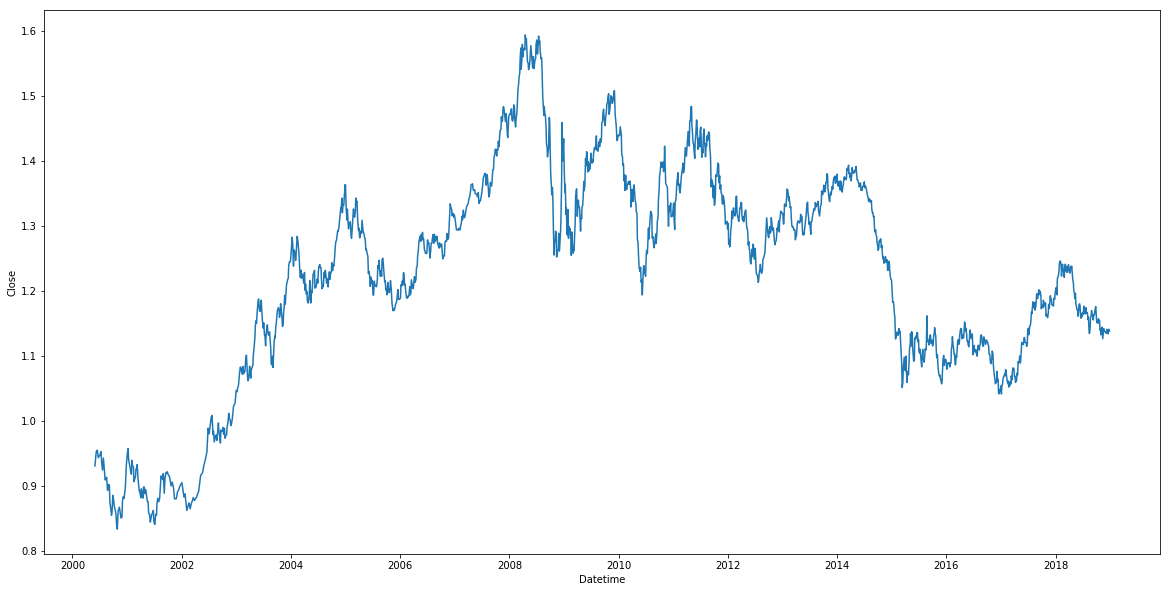

In [6]:
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(y=df_train['Close'][df_train.index%3600 == 0], x=df_train['Datetime'][df_train.index%3600 == 0])

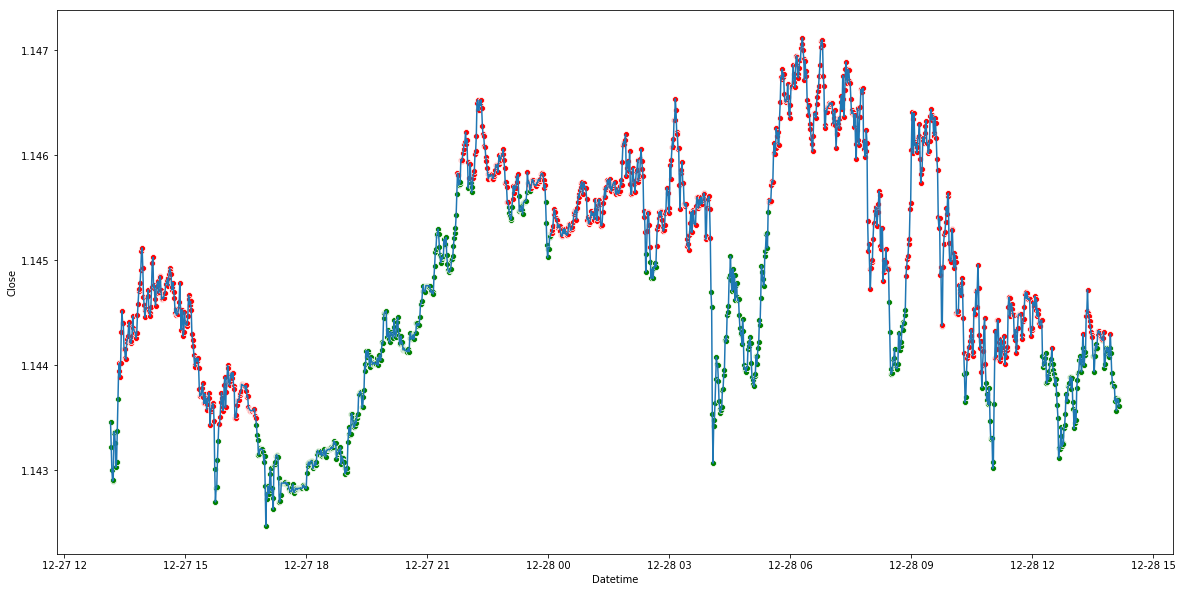

In [7]:
fig, ax = plt.subplots(figsize=(20,10))
df_go_long = df_train.iloc[6163500:6165000]
df_go_short = df_go_long.loc[df_train['goLong'] == 0]
df_go_long = df_go_long.loc[df_train['goLong'] == 1]
sns.lineplot(y=df_train['Close'][6163500:6165000], x=df_train['Datetime'][6163500:6165000])
sns.scatterplot(y=df_go_long['Close'], x=df_train['Datetime'], color='green')
sns.scatterplot(y=df_go_short['Close'], x=df_train['Datetime'], color='red')

# Now let's do some ML stuff :O

### Normalize data

In [8]:
from sklearn import preprocessing

def normalize(df):
    df = df[df['Close'] < 500]
    df_norm = df.copy()
    min_max_scaler = preprocessing.MinMaxScaler()
    df_norm[['Open','Highest','Close', 'Lowest']] = min_max_scaler.fit_transform(df_norm[['Open','Highest','Close', 'Lowest']])
    return df_norm

In [9]:
df_train_norm = normalize(df_train)
df_test_norm = normalize(df_test)

In [10]:
df_train_norm.head()

,Datetime,Open,Highest,Close,Lowest,goLong
0,2000-05-30 17:27:00,0.580096,0.579915,0.580241,0.580024,1
1,2000-05-30 17:35:00,0.580221,0.580102,0.580365,0.580211,0
2,2000-05-30 17:38:00,0.580221,0.580040,0.580303,0.580086,0
3,2000-05-30 17:43:00,0.580034,0.579853,0.580116,0.579899,1
4,2000-05-30 17:44:00,0.579847,0.579666,0.579929,0.579712,1


In [11]:
df_test_norm.head()

,Datetime,Open,Highest,Close,Lowest,goLong
0,2019-01-01 17:02:00,0.761625,0.759895,0.763802,0.761460,0
1,2019-01-01 17:03:00,0.761625,0.761644,0.763802,0.763415,0
2,2019-01-01 17:04:00,0.763581,0.761644,0.765534,0.763198,0
3,2019-01-01 17:05:00,0.763364,0.764706,0.765534,0.766457,0
4,2019-01-01 17:06:00,0.766189,0.774546,0.765101,0.776016,0


In [30]:
# raw_X_train = df_train_norm[['Open','Highest','Close', 'Lowest']].to_numpy()
raw_X_train = df_train_norm[['Close']].to_numpy()
raw_y_train = df_train_norm[['goLong']].to_numpy()

minutes_per_sample = 240

X_train = []
y_train = []

for i, minute in enumerate(tqdm(raw_X_train)):
    if i%250 != 0:
        continue
    if(i < len(raw_X_train) - minutes_per_sample):
        X_train.append(np.concatenate(raw_X_train[i : minutes_per_sample + i], axis=0))
        y_train.append(raw_y_train[minutes_per_sample + i][0])

100%|██████████| 6166607/6166607 [00:05<00:00, 1171424.61it/s]


In [31]:
X_train[0]

array([0.58024075, 0.5803655 , 0.58030312, 0.58011601, 0.5799289 ,
       0.57999127, 0.58011601, 0.58005364, 0.58011601, 0.57999127,
       0.58011601, 0.58005364, 0.58011601, 0.58005364, 0.57999127,
       0.57999127, 0.58011601, 0.57999127, 0.5799289 , 0.57986653,
       0.5799289 , 0.57986653, 0.5799289 , 0.57999127, 0.58005364,
       0.58005364, 0.57999127, 0.57999127, 0.58011601, 0.58005364,
       0.57999127, 0.57999127, 0.5799289 , 0.57980415, 0.57980415,
       0.57986653, 0.5799289 , 0.57986653, 0.57980415, 0.57967941,
       0.57967941, 0.57974178, 0.57974178, 0.57980415, 0.57980415,
       0.57986653, 0.57986653, 0.5799289 , 0.57980415, 0.57986653,
       0.5799289 , 0.57980415, 0.5799289 , 0.58005364, 0.58049024,
       0.58055261, 0.58055261, 0.58073972, 0.5808021 , 0.58067735,
       0.58073972, 0.58067735, 0.58061498, 0.58055261, 0.58067735,
       0.58055261, 0.58061498, 0.58073972, 0.5808021 , 0.58073972,
       0.58067735, 0.58073972, 0.58086447, 0.58098921, 0.58086

In [32]:
raw_X_test = df_test_norm[['Close']].to_numpy()
raw_y_test = df_test_norm[['goLong']].to_numpy()

minutes_per_sample = 240

X_test = []
y_test = []

for i, minute in enumerate(tqdm(raw_X_test)):
    if i%30 != 0:
        continue
    if(i < len(raw_X_test) - minutes_per_sample):
        X_test.append(np.concatenate(raw_X_test[i : minutes_per_sample + i], axis=0))
        y_test.append(raw_y_test[minutes_per_sample + i][0])

100%|██████████| 190658/190658 [00:00<00:00, 301129.13it/s]


In [33]:
len(X_test)

6348

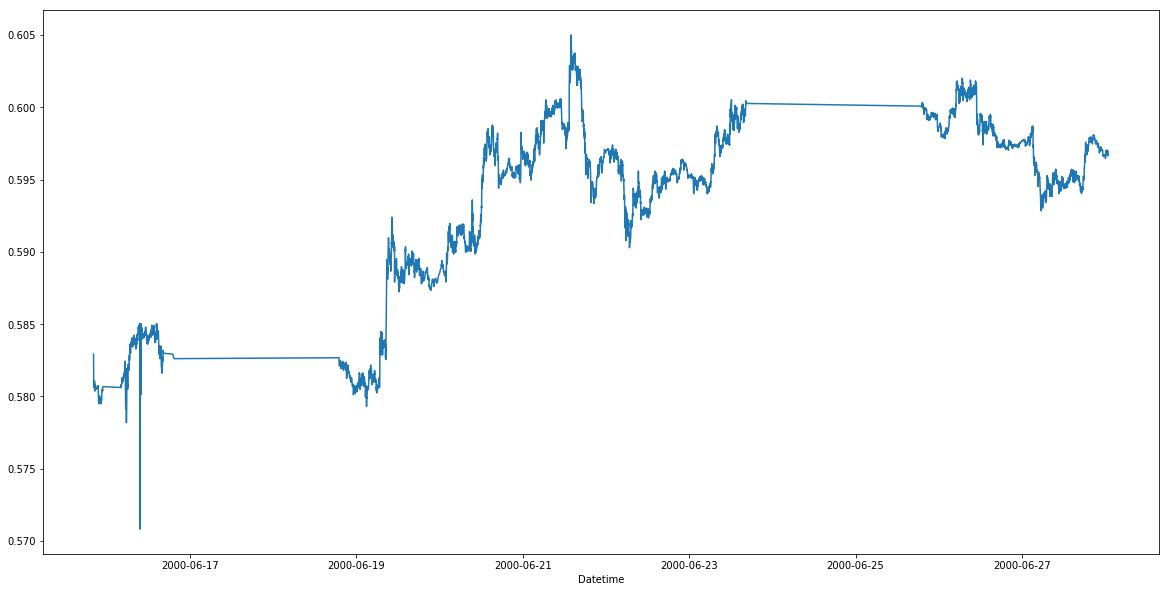

In [28]:
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(y=X_train[1], x=df_train['Datetime'][7200:14400])

In [29]:
y_train[0]

1

In [41]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(verbose=1, n_estimators=7000)
gbc.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.3855           37.22m
         2           1.3851           37.33m
         3           1.3848           37.33m
         4           1.3844           37.29m
         5           1.3838           37.06m
         6           1.3835           37.02m
         7           1.3833           36.97m
         8           1.3829           36.85m
         9           1.3826           36.86m
        10           1.3825           36.86m
        20           1.3793           36.65m
        30           1.3764           36.62m
        40           1.3732           36.63m
        50           1.3700           36.61m
        60           1.3668           36.56m
        70           1.3637           36.52m
        80           1.3604           36.41m
        90           1.3573           36.38m
       100           1.3536           36.31m
       200           1.3255           35.73m
       300           1.2973           35.16m
       40

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=7000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=1, warm_start=False)

In [42]:
gbc.score(X_test, y_test)

0.49354127284183996

THIS SUCKS

# Let's try to predict future with classic RNN

https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/23_Time-Series-Prediction.ipynb